# LLAMA 2

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import bitsandbytes as bnb
from sklearn.model_selection import StratifiedShuffleSplit
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)
from huggingface_hub import notebook_login
from matplotlib import pyplot as plt
from tensorboard import notebook


import warnings
warnings.filterwarnings('ignore')

No Bottleneck unit testing available.


2024-01-28 11:20:30.769591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 11:20:30.769634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 11:20:30.770362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 11:20:30.774961: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 11:20:31.576627: W tensorflow/compiler/tf2

## Helper function

### Prompts

In [2]:
def generate_prompt(data_point):
    return f"""Analyze the sentiment of the sentence enclosed in square brackets, determine if it is happiness or fear or anger or sadness or disgust or shame or guilt or surprise, and return the answer by one word as the corresponding sentiment label 'happiness' or 'fear' or 'anger' or 'sadness' or 'disgust' or 'shame' or'guilt' or 'surprise'.
            [{data_point["preprocessed_text"]}] = {data_point["emotion"]}""".strip()

def generate_test_prompt(data_point):
    return f"""Analyze the sentiment of the sentence enclosed in square brackets, determine if it is happiness or fear or anger or sadness or disgust or shame or guilt or surprise, and return the answer by one word as the corresponding sentiment label 'happiness' or 'fear' or 'anger' or 'sadness' or 'disgust' or 'shame' or'guilt' or 'surprise'.
            [{data_point["preprocessed_text"]}] = """.strip()

### Predict

In [3]:
def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens = 10,
                        temperature = 0.1, 
                        return_full_text=False
                       )
        result = pipe(prompt)
        generated_text = result[0]['generated_text']

        emotion = generated_text.split()[0]
        answer = ''.join([x for x in emotion if x.isalnum()])

        if "happiness" in answer:
            y_pred.append("happiness")
        elif "fear" in answer:
            y_pred.append("fear")
        elif "anger" in answer:
            y_pred.append("anger")
        elif "sadness" in answer:
            y_pred.append("sadness")
        elif "disgust" in answer:
            y_pred.append("disgust")
        elif "shame" in answer:
            y_pred.append("shame")
        elif "guilt" in answer:
            y_pred.append("guilt")
        elif "surprise" in answer:
            y_pred.append("surprise")
        else:
            y_pred.append("none")
    return y_pred
    

### Evaluate

In [4]:
def evaluate(y_true, y_pred):
    labels = ['happiness', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt', 'surprise']
    
    mapping = {
        'happiness': 0,
        'fear': 1,
        'anger': 2,
        'sadness': 3,
        'disgust': 4,
        'shame': 5,
        'guilt': 6,
        'surprise': 7,
    }

    reverse_mapping = {v: k for k, v in mapping.items()}  # Reverse mapping for converting numbers to labels

    def map_func(x):
        return mapping.get(x, 1)

    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label_num in unique_labels:
        label = reverse_mapping[label_num]
        label_indices = [i for i in range(len(y_true)) if y_true[i] == label_num]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=[reverse_mapping[label_num] for label_num in y_true],
                                         y_pred=[reverse_mapping[label_num] for label_num in y_pred])
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])
    print('\nConfusion Matrix:')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.show()

## Data

In [5]:
df = pd.read_csv('full_dataset/full_dataset.csv')
data = df[['emotion', 'preprocessed_text']]

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, test_valid_index in split.split(data, data['emotion']):
    train_set = data.iloc[train_index]
    test_valid_set = data.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set['emotion']):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]
    
X_train = train_set.reset_index(drop=True)

In [7]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1),
                       columns=["text"])
X_eval = pd.DataFrame(valid_set.apply(generate_prompt, axis=1),
                      columns=["text"])
                      
y_true = test_set.emotion
X_test = pd.DataFrame(test_set.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

In [8]:
notebook_login()

In [9]:
model_name = "meta-llama/Llama-2-7b-hf"

compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto"
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                         use_auth_token=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
y_pred = predict(X_test, model, tokenizer)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1961/1961 [15:23<00:00,  2.12it/s]


Accuracy: 0.420
Accuracy for happiness: 0.881
Accuracy for fear: 0.455
Accuracy for anger: 0.448
Accuracy for sadness: 0.356
Accuracy for disgust: 0.255
Accuracy for shame: 0.173
Accuracy for guilt: 0.221
Accuracy for surprise: 0.326

Classification Report:
              precision    recall  f1-score   support

       anger       0.45      0.45      0.45       310
     disgust       0.77      0.26      0.38       231
        fear       0.42      0.45      0.44       299
       guilt       0.44      0.22      0.29       208
   happiness       0.30      0.88      0.45       310
     sadness       0.75      0.36      0.48       323
       shame       0.59      0.17      0.27       237
    surprise       0.56      0.33      0.41        43

    accuracy                           0.42      1961
   macro avg       0.53      0.39      0.40      1961
weighted avg       0.53      0.42      0.41      1961


Confusion Matrix:


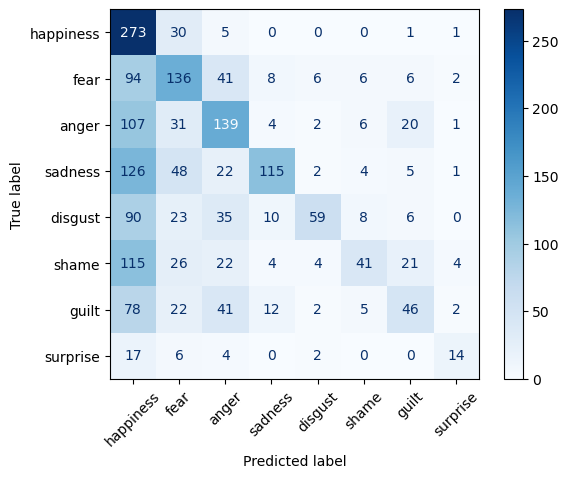

In [11]:
evaluate(y_true, y_pred)

In [12]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir="./resultsLlama",
    num_train_epochs=10,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # 4
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="epoch"
)

In [13]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=1024,
)

Map:   0%|          | 0/5883 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

In [14]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained("trained-model-llama")

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,0.700400,0.584463
1,0.548300,0.577476
2,0.521000,0.577360
3,0.556700,0.588153
4,0.393400,0.603914
5,0.511300,0.633528
6,0.348700,0.669908
8,0.331300,0.716971
9,0.255400,0.726110


In [15]:
y_pred = predict(X_test, model, tokenizer)

  0%|                                                                                                                                    | 0/1961 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1961/1961 [19:29<00:00,  1.68it/s]


Accuracy: 0.768
Accuracy for happiness: 0.887
Accuracy for fear: 0.873
Accuracy for anger: 0.774
Accuracy for sadness: 0.836
Accuracy for disgust: 0.684
Accuracy for shame: 0.641
Accuracy for guilt: 0.543
Accuracy for surprise: 0.860

Classification Report:
              precision    recall  f1-score   support

       anger       0.71      0.77      0.74       310
     disgust       0.74      0.68      0.71       231
        fear       0.84      0.87      0.86       299
       guilt       0.60      0.54      0.57       208
   happiness       0.86      0.89      0.88       310
     sadness       0.80      0.84      0.82       323
       shame       0.70      0.64      0.67       237
    surprise       0.95      0.86      0.90        43

    accuracy                           0.77      1961
   macro avg       0.78      0.76      0.77      1961
weighted avg       0.77      0.77      0.77      1961


Confusion Matrix:


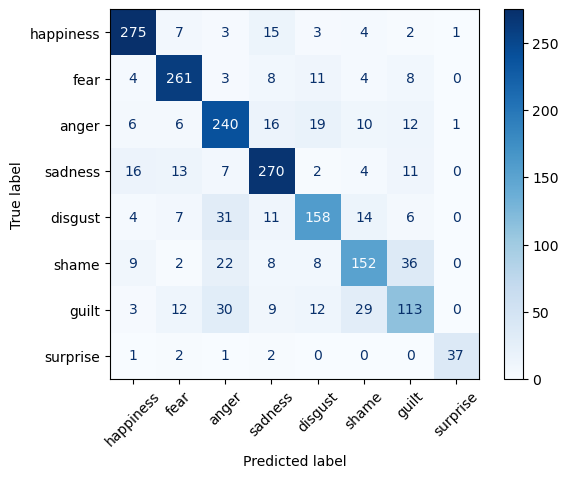

In [16]:
evaluate(y_true, y_pred)

In [17]:
evaluation = pd.DataFrame({'text': X_test["text"], 
                           'y_true':y_true, 
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)